In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Banipreet\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import os
start_token = " "

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]

In [4]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


In [5]:
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

max length = 16


In [6]:
#all unique characters go here
tokens = set(''.join(names[:])) #<all unique characters in the dataset>

tokens = list(tokens)

n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)

assert 50 < n_tokens < 60


n_tokens =  55


In [7]:
token_to_id = {} ###YOUR CODE HERE: create a dictionary of {symbol -> its  index in tokens }
for i in range(n_tokens):
    token_to_id[tokens[i]] = i 

In [8]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

In [9]:
def to_matrix(names,max_len=None,pad=0,dtype='int32'):
    max_len = max_len or max(map(len,names))
    names_ix = np.zeros([len(names),max_len],dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get,names[i]))
        names_ix[i,:len(name_ix)] = name_ix

    return names_ix.T

In [10]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]).T)

 Abagael
 Glory
 Prissie
 Giovanne
[[54 21 22 12 44 12 11 38  0]
 [54 37 38 45 23 51  0  0  0]
 [54  6 23  9 33 33  9 11  0]
 [54 37  9 45  5 12  8  8 11]]


In [11]:
import keras
from keras.layers import Concatenate,Dense,Embedding

rnn_num_units = 64
embedding_size = 16

#Let's create layers for our recurrent network
#Note: we create layers but we don't "apply" them yet
embed_x = Embedding(n_tokens,embedding_size) # an embedding layer that converts character ids into embeddings
#we have vocab of n_tokens and we make the vector space of 16 dimensions, thats why

#a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
get_h_next = Dense(rnn_num_units, activation='relu')

#a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas = Dense(n_tokens, activation='softmax')

#Note: please either set the correct activation to Dense or write it manually in rnn_one_step

Using TensorFlow backend.


In [12]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces next state and output
    given prev input and previous state.
    We'll call this method repeatedly to produce the whole sequence.
    
    Follow inline isntructions to complete the function.
    """
    #convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t,[-1,1]))[:,0]
    
    #concatenate x embedding and previous h state
    x_and_h = tf.concat([x_t_emb,h_t],1)
    
    #compute next state given x_and_h
    h_next = get_h_next(x_and_h)
    
    #get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next)
    
    return output_probas,h_next

In [13]:
input_sequence = tf.placeholder('int32',(MAX_LENGTH,None))
batch_size = tf.shape(input_sequence)[1]

predicted_probas = []
h_prev = tf.zeros([batch_size,rnn_num_units]) #initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[t]
    probas_next,h_next = rnn_one_step(x_t,h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
predicted_probas = tf.stack(predicted_probas)

In [14]:
predictions_matrix = tf.reshape(predicted_probas[:-1],[-1,len(tokens)])
answers_matrix = tf.one_hot(tf.reshape(input_sequence[1:],[-1]), n_tokens)

In [16]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=answers_matrix, logits=predictions_matrix))#<define loss as categorical crossentropy. Mind that predictions are probabilities and NOT logits!>

optimize = tf.train.AdamOptimizer().minimize(loss)

### The training loop

In [17]:
from IPython.display import clear_output
from random import sample
s = keras.backend.get_session()
s.run(tf.global_variables_initializer())
history = []

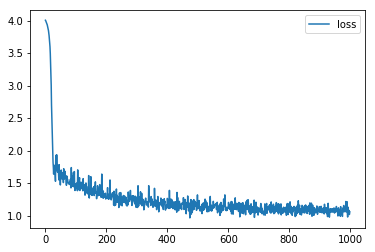

In [16]:

for i in range(1000):
    batch = to_matrix(sample(names,32),max_len=MAX_LENGTH)
    loss_i,_ = s.run([loss,optimize],{input_sequence:batch})
    
    
    history.append(loss_i)
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. All we need is the `rnn_one_step` function you have written above.

In [17]:
x_t = tf.placeholder('int32',(None,))
h_t = tf.Variable(np.zeros([1,rnn_num_units],'float32'))

next_probs,next_h = rnn_one_step(x_t,h_t)

In [18]:
def generate_sample(seed_phrase=' ',max_length=MAX_LENGTH):
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t,h_t.initial_value))
    
    #feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t,next_h),{x_t:[ix]})
    
    #start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs,tf.assign(h_t,next_h)],{x_t:[x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens,p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence])

In [19]:
for _ in range(10):
    print(generate_sample())

 ElirtiJJJJJJJJJ
 SobiniJJJJJJJJJ
 BlytJJJJJJJJJJJ
 BalimuaJJJJJJJJ
 EsyveriJJJJJJJJ
 MisniaJJJJJJJJJ
 KebidceJJJJJJJJ
 TorgoldonaJJJJJ
 CrytenJJJJJJJJJ
 GazoqeydJJJJJJJ


In [20]:
for _ in range(50):
    print(generate_sample(' Trump'))

 TrumpzyaJJJJJJJ
 TrumpaleJJJJJJJ
 TrumpeJJJJJJJJJ
 TrumplaJJJJJJJJ
 TrumpeJJJJJJJJJ
 TrumporirdJJJJJ
 TrumphendaJJJJJ
 TrumpeJJJJJJJJJ
 TrumpelJJJJJJJJ
 TrumpeleigJJJJJ
 TrumpiaJJJJJJJJ
 TrumphsJJJJJJJJ
 TrumpeeJJJJJJJJ
 TrumpueJJJJJJJJ
 TrumphaJJJJJJJJ
 TrumpamJJJJJJJJ
 TrumpyeJdJJJJJJ
 TrumpJJJJJJJJJJ
 TrumpalpJJJJJJJ
 TrumpeJJJJJJJJJ
 TrumpyJJJJJJJJJ
 TrumponJJJJJJJJ
 TrumpedJJJJJJJJ
 TrumpkiJJJJJJJJ
 TrumpliJnJJJJJJ
 TrumphiyJJJJJJJ
 TrumpiAJJJJJJJJ
 TrumponJJJJJJJJ
 TrumpeyJJJJJJJJ
 TrumpiaJJJJJJJJ
 TrumprJJJJJJJJJ
 TrumpabJJJJJJJJ
 TrumpyJJJJJJJJJ
 TrumpiaJJJJJJJJ
 TrumptiaJJJJJJJ
 TrumpaJJJJJJJJJ
 TrumpaJJJJJJJJJ
 TrumptapeJJJJJJ
 TrumponedtJJJJJ
 TrumporJJJJJJJJ
 TrumporaseJJJJJ
 TrumpeJJJJJJJJJ
 TrumphamloeJJJJ
 TrumpesJJJJJJJJ
 TrumplycaJJJJJJ
 TrumpheJJJJJJJJ
 TrumpkJJJJJJJJJ
 TrumpJJJJJJJJJJ
 TrumpadJJJJJJJJ
 TrumpiaJJJJJJJJ
